## Initial Imports

In [1]:
import numpy as np
import pandas as pd
import ipdb
import pprint
import sys
import matplotlib.pyplot as plt
import math
import operator
from tabulate import tabulate

eps = np.finfo(float).eps
from numpy import log2 as log

# Q1-1-1, Q-1-1-2 : Robot1 & Robot2

## Reading Data

### Robot1

In [4]:
data_robot = []
training_data_robot = []
validation_data_robot = []

data = pd.read_csv("../input_data/RobotDataset/Robot1", delim_whitespace=True, header=None)
data_robot.append(data)

# Random Selection of 80% Training Data and 20% Validation Data
msk = np.random.rand(len(data_robot[0])) < 0.8
training_data_robot.append(data_robot[0][msk].reset_index(drop=True))
validation_data_robot.append(data_robot[0][~msk].reset_index(drop=True))

# Selecting first 80% as Training Data and remaining as Validation Data
# train, validate = np.split(data_robot[0], [int(.8*len(data_robot[0]))])
# training_data_robot.append(train)
# validation_data_robot.append(validate.reset_index(drop=True))

### Robot2

In [6]:
data = pd.read_csv("../input_data/RobotDataset/Robot2", delim_whitespace=True, header=None)
data_robot.append(data)

# Random Selection of 80% Training Data and 20% Validation Data
msk = np.random.rand(len(data_robot[1])) < 0.8
training_data_robot.append(data_robot[1][msk].reset_index(drop=True))
validation_data_robot.append(data_robot[1][~msk].reset_index(drop=True))

# Selecting first 80% as Training Data and remaining as Validation Data
# train, validate = np.split(data_robot[1], [int(.8*len(data_robot[1]))])
# training_data_robot.append(train)
# validation_data_robot.append(validate.reset_index(drop=True))

## Utility Functions

In [23]:
distances_list_robot = [[],[]]

def robot_get_distances(idx, test_sample, training_data, distance_measure):
    distances = []
    p = 1
    if distance_measure == "Euclidean":
        p = 2
    elif distance_measure == "Minkowski":
        p = 5

    for index, row in training_data.iterrows():
        dist = 0
        for i in range(1, 7):
            d = abs(test_sample[i] - row[i])
            dist += pow(d, p)
        distances.append(((dist ** (1./p)), row[0]))

    distances = sorted(distances, key = operator.itemgetter(0))
    distances_list_robot[idx].append(distances)

In [24]:
def robot_kNN_validation(distances_list, validation_data, k):
    TP = 0; FP = 0; TN = 0; FN = 0;

    for index, validation_sample in validation_data.iterrows():
        distances = distances_list[index]

        nOnes = 0
        for i in range(k):
            if distances[i][1] == 1:
                nOnes += 1
        nZeros = k - nOnes
        if nOnes > nZeros:
            prediction = 1
        else:
            prediction = 0

        if prediction == 1:
            if validation_sample[0] == 1:
                TP += 1
            else:
                FP += 1
        else:
            if validation_sample[0] == 0:
                TN += 1
            else:
                FN += 1

    accuracy = float(TP + TN) / (TP + FP + TN + FN)
    if TP == 0:
        recall = 0.0
        precision = 0.0
        f1_score = 2 / ((1/(eps)) + (1/(eps)))
    else:
        recall = float(TP) / (TP + FN)
        precision = float(TP) / (TP + FP)
        f1_score = 2 / ((1/(recall)) + (1/(precision)))

    return (round(accuracy * 100, 2), round(recall * 100, 2), round(precision * 100, 2), round(f1_score, 2))

In [27]:
performance_robot = []

def robots_update_distances(distance_measure):
    global distances_list_robot
    distances_list_robot = [[], []]
    for idx in range(2):
        for index, validation_sample in validation_data_robot[idx].iterrows():
            robot_get_distances(idx, validation_sample, training_data_robot[idx], distance_measure)

    global performance_robot
    performance_robot = []
    performance_robot.append(pd.DataFrame(columns=['K', 'accuracy (%)', 'recall (%)', 'precision (%)', 'f1_score']))
    performance_robot.append(pd.DataFrame(columns=['K', 'accuracy (%)', 'recall (%)', 'precision (%)', 'f1_score']))

    for robot_idx in range(2):
        for k in range(1, 16, 2):
            accuracy, recall, precision, f1_score = robot_kNN_validation(distances_list_robot[robot_idx], validation_data_robot[robot_idx], k)
            performance_robot[robot_idx] = performance_robot[robot_idx].append(pd.DataFrame([[k, accuracy, recall, precision, f1_score]], columns=['K', 'accuracy (%)', 'recall (%)', 'precision (%)', 'f1_score']), ignore_index=True)

## Distance Measure :- Euclidean

### **Robot1**

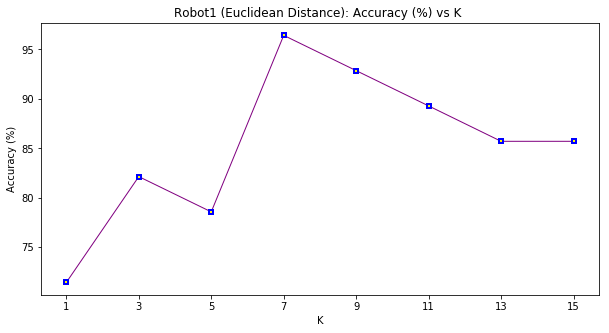

K,accuracy (%),recall (%),precision (%),f1_score
1,71.43,61.11,91.67,0.73
3,82.14,72.22,100,0.84
5,78.57,77.78,87.5,0.82
7,96.43,94.44,100,0.97
9,92.86,88.89,100,0.94
11,89.29,83.33,100,0.91
13,85.71,83.33,93.75,0.88
15,85.71,83.33,93.75,0.88


In [28]:
robots_update_distances("Euclidean")

x = list(performance_robot[0]["K"])
y = list(performance_robot[0]["accuracy (%)"])

fig, ax = plt.subplots(figsize=(10,5))

ax.plot(x, y, color="purple", lw=1, ls='-', marker='s', markersize=4, 
        markerfacecolor="yellow", markeredgewidth=2, markeredgecolor="blue");

plt.xticks(x)
plt.title("Robot1 (Euclidean Distance): Accuracy (%) vs K ")
plt.ylabel("Accuracy (%)")
plt.xlabel("K")
plt.show()

performance_robot[0].style.hide_index()
# print(tabulate(performance_robot[0], headers='keys', tablefmt='psql', showindex=False))

Keeping the value of K very small may lead to erroneous predictions.<br>
Alternatively, choosing a large value for K  may lead to a large model bias. <br>
Thus, K should be set to a value large enough to minimize the probability of misclassification <br> 
and small enough so that the K nearest points are closer to the query point.

### Robot2

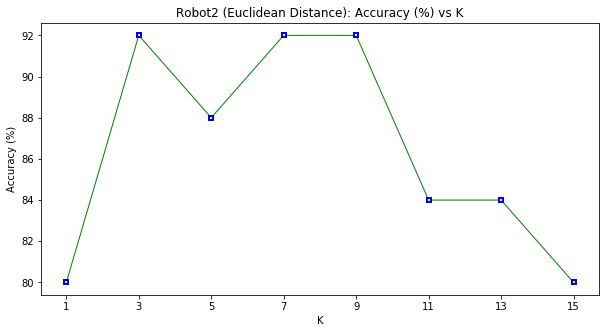

K,accuracy (%),recall (%),precision (%),f1_score
1,80,81.82,75,0.78
3,92,81.82,100,0.9
5,88,81.82,90,0.86
7,92,81.82,100,0.9
9,92,81.82,100,0.9
11,84,63.64,100,0.78
13,84,63.64,100,0.78
15,80,63.64,87.5,0.74


In [29]:
x = list(performance_robot[1]["K"])
y = list(performance_robot[1]["accuracy (%)"])

fig, ax = plt.subplots(figsize=(10,5))

ax.plot(x, y, color="green", lw=1, ls='-', marker='s', markersize=4, 
        markerfacecolor="yellow", markeredgewidth=2, markeredgecolor="blue");

plt.xticks(x)
plt.title("Robot2 (Euclidean Distance): Accuracy (%) vs K")
plt.ylabel("Accuracy (%)")
plt.xlabel("K")
plt.show()

performance_robot[1].style.hide_index()
# print(tabulate(performance_robot[1], headers='keys', tablefmt='psql', showindex=False))

## Distance Measure :- Minkowski

### Robot1

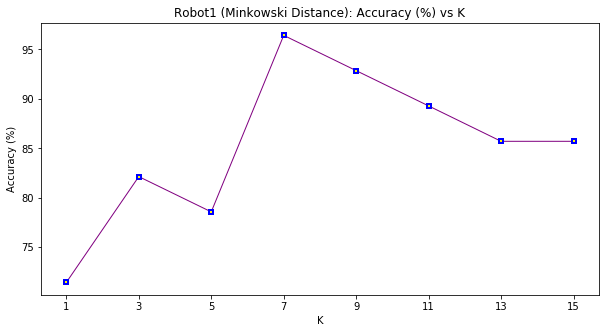

K,accuracy (%),recall (%),precision (%),f1_score
1,71.43,61.11,91.67,0.73
3,82.14,72.22,100,0.84
5,78.57,77.78,87.5,0.82
7,96.43,94.44,100,0.97
9,92.86,88.89,100,0.94
11,89.29,83.33,100,0.91
13,85.71,83.33,93.75,0.88
15,85.71,83.33,93.75,0.88


In [30]:
robots_update_distances("Minkowski")

x = list(performance_robot[0]["K"])
y = list(performance_robot[0]["accuracy (%)"])

fig, ax = plt.subplots(figsize=(10,5))

ax.plot(x, y, color="purple", lw=1, ls='-', marker='s', markersize=4, 
        markerfacecolor="yellow", markeredgewidth=2, markeredgecolor="blue");

plt.xticks(x)
plt.title("Robot1 (Minkowski Distance): Accuracy (%) vs K")
plt.ylabel("Accuracy (%)")
plt.xlabel("K")
plt.show()

performance_robot[0].style.hide_index()
# print(tabulate(performance_robot[0], headers='keys', tablefmt='psql', showindex=False))

### Robot2

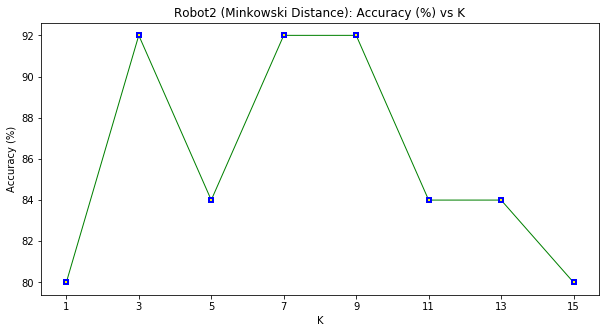

K,accuracy (%),recall (%),precision (%),f1_score
1,80,81.82,75,0.78
3,92,81.82,100,0.9
5,84,81.82,81.82,0.82
7,92,81.82,100,0.9
9,92,81.82,100,0.9
11,84,63.64,100,0.78
13,84,63.64,100,0.78
15,80,63.64,87.5,0.74


In [31]:
x = list(performance_robot[1]["K"])
y = list(performance_robot[1]["accuracy (%)"])

fig, ax = plt.subplots(figsize=(10,5))

ax.plot(x, y, color="green", lw=1, ls='-', marker='s', markersize=4, 
        markerfacecolor="yellow", markeredgewidth=2, markeredgecolor="blue");

plt.xticks(x)
plt.title("Robot2 (Minkowski Distance): Accuracy (%) vs K")
plt.ylabel("Accuracy (%)")
plt.xlabel("K")
plt.show()

performance_robot[1].style.hide_index()
# print(tabulate(performance_robot[1], headers='keys', tablefmt='psql', showindex=False))

## Distance Measure :- Manhattan

### Robot1

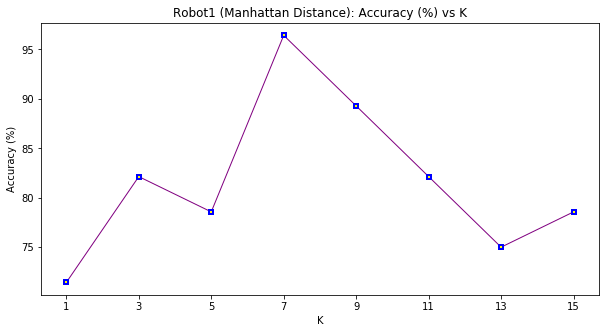

K,accuracy (%),recall (%),precision (%),f1_score
1,71.43,61.11,91.67,0.73
3,82.14,72.22,100,0.84
5,78.57,77.78,87.5,0.82
7,96.43,94.44,100,0.97
9,89.29,83.33,100,0.91
11,82.14,72.22,100,0.84
13,75,66.67,92.31,0.77
15,78.57,72.22,92.86,0.81


In [32]:
robots_update_distances("Manhattan")

x = list(performance_robot[0]["K"])
y = list(performance_robot[0]["accuracy (%)"])

fig, ax = plt.subplots(figsize=(10,5))

ax.plot(x, y, color="purple", lw=1, ls='-', marker='s', markersize=4, 
        markerfacecolor="yellow", markeredgewidth=2, markeredgecolor="blue");

plt.xticks(x)
plt.title("Robot1 (Manhattan Distance): Accuracy (%) vs K")
plt.ylabel("Accuracy (%)")
plt.xlabel("K")
plt.show()

performance_robot[0].style.hide_index()
# print(tabulate(performance_robot[0], headers='keys', tablefmt='psql', showindex=False))

### Robot2

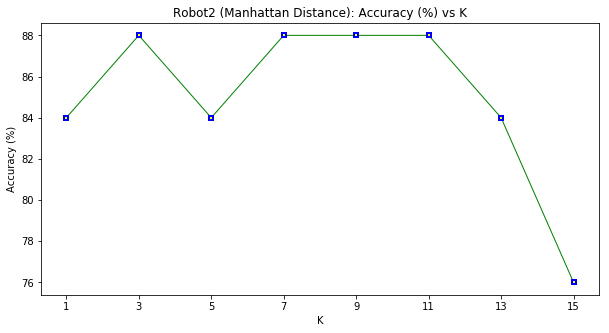

K,accuracy (%),recall (%),precision (%),f1_score
1,84,72.73,88.89,0.8
3,88,81.82,90,0.86
5,84,72.73,88.89,0.8
7,88,81.82,90,0.86
9,88,81.82,90,0.86
11,88,81.82,90,0.86
13,84,81.82,81.82,0.82
15,76,72.73,72.73,0.73


In [33]:
x = list(performance_robot[1]["K"])
y = list(performance_robot[1]["accuracy (%)"])

fig, ax = plt.subplots(figsize=(10,5))

ax.plot(x, y, color="green", lw=1, ls='-', marker='s', markersize=4, 
        markerfacecolor="yellow", markeredgewidth=2, markeredgecolor="blue");

plt.xticks(x)
plt.title("Robot2 (Manhattan Distance): Accuracy (%) vs K")
plt.ylabel("Accuracy (%)")
plt.xlabel("K")
plt.show()

performance_robot[1].style.hide_index()
# print(tabulate(performance_robot[1], headers='keys', tablefmt='psql', showindex=False))

# Q-1-2-1, Q-1-2-2: Iris

## Reading Data

In [34]:
data_iris = pd.read_csv("../input_data/Iris/Iris.csv", header=None)
data_iris.columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal width', 'class']
# Random Selection of 80% Training Data and 20% Validation Data
msk = np.random.rand(len(data_robot[1])) < 0.8
training_data_robot.append(data_robot[1][msk].reset_index(drop=True))
validation_data_robot.append(data_robot[1][~msk].reset_index(drop=True))

# Selecting first 80% as Training Data and remaining as Validation Data
# training_data_iris, validation_data_iris= np.split(data_iris, [int(.8*len(data_iris))])
# validation_data_iris = validation_data_iris.reset_index(drop=True)

## Utility Functions

In [35]:
distances_list_iris = []

def iris_get_distances(test_sample, training_data, distance_measure):
    distances = []
    p = 1
    if distance_measure == "Euclidean":
        p = 2
    elif distance_measure == "Minkowski":
        p = 5

    columns = training_data.columns
    for index, row in training_data.iterrows():
        dist = 0
        for col in columns[:-1]:
            d = abs(test_sample[col] - row[col])
            dist += pow(d, p)
        distances.append(((dist ** (1./p)), row['class']))

    distances = sorted(distances, key = operator.itemgetter(0))
    distances_list_iris.append(distances)

In [36]:
def iris_kNN_validation(distances_list, validation_data, k):
    TP = 0; FP = 0; TN = 0; FN = 0;
    correct = 0;

    actual_labels = []
    predicted_labels = []

    nColumns = len(validation_data.columns)
    for index, validation_sample in validation_data.iterrows():
        distances = distances_list[index]

        labels_count = {}
        for i in range(k):
            if distances[i][1] not in labels_count:
                labels_count[distances[i][1]] = 1
            else:
                labels_count[distances[i][1]] += 1
        
        prediction = max(labels_count.items(), key=operator.itemgetter(1))[0]
        
        actual_labels.append(validation_sample[nColumns-1])
        predicted_labels.append(prediction)

    y_actu = pd.Series(actual_labels, name='Actual')
    y_pred = pd.Series(predicted_labels, name='Predicted')
    df_confusion = pd.crosstab(y_actu, y_pred, margins=True)
    
    labels_names = training_data_iris['class'].unique()
    precision = {}
    recall = {}
    f1_score = {}
    for label in labels_names:
        correct += df_confusion[label][label]
        _precision = float(df_confusion[label][label]) / df_confusion['All'][label]
        precision[label] = round(_precision * 100, 2)
        _recall = float(df_confusion[label][label]) / df_confusion[label]['All']
        recall[label] = round(_recall * 100, 2)

        if _recall == 0.0:
            _recall = eps
        if _precision == 0.0:
            _precision = eps

        f1_score[label] = round((2 / ((1/_recall) + (1/_precision))), 2)

    accuracy = round((float(correct) / df_confusion['All']['All']) * 100, 2)
    return (accuracy, precision, recall, f1_score)

In [37]:
performance_iris = None

def iris_update_distances(distance_measure):
    global distances_list_iris
    distances_list_iris = []
    for index, validation_sample in validation_data_iris.iterrows():
        iris_get_distances(validation_sample, training_data_iris, distance_measure)

    global performance_iris
    performance_iris = pd.DataFrame(columns=['K', 'accuracy (%)'])

    for k in range(1, 16, 2):
        accuracy, precision, recall, f1_score = iris_kNN_validation(distances_list_iris, validation_data_iris, k)
        performance_iris = performance_iris.append(pd.DataFrame([[k, accuracy, recall, precision, f1_score]], columns=['K', 'accuracy (%)', 'precision (%)', 'recall (%)', 'f1_score']), ignore_index=True)

## Distance Measure :- Euclidean

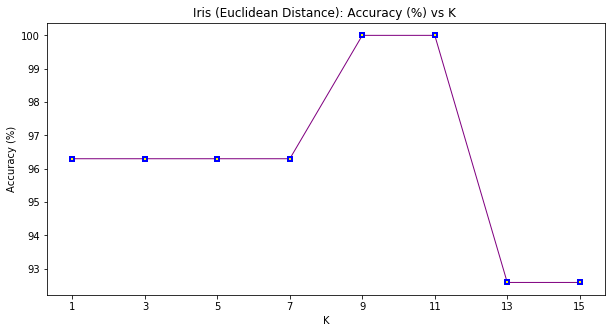

K,accuracy (%),f1_score,precision (%),recall (%)
1,96.3,"{'Iris-setosa': 1.0, 'Iris-virginica': 0.92, 'Iris-versicolor': 0.95}","{'Iris-setosa': 100.0, 'Iris-virginica': 85.71, 'Iris-versicolor': 100.0}","{'Iris-setosa': 100.0, 'Iris-virginica': 100.0, 'Iris-versicolor': 90.0}"
3,96.3,"{'Iris-setosa': 1.0, 'Iris-virginica': 0.92, 'Iris-versicolor': 0.95}","{'Iris-setosa': 100.0, 'Iris-virginica': 85.71, 'Iris-versicolor': 100.0}","{'Iris-setosa': 100.0, 'Iris-virginica': 100.0, 'Iris-versicolor': 90.0}"
5,96.3,"{'Iris-setosa': 1.0, 'Iris-virginica': 0.92, 'Iris-versicolor': 0.95}","{'Iris-setosa': 100.0, 'Iris-virginica': 85.71, 'Iris-versicolor': 100.0}","{'Iris-setosa': 100.0, 'Iris-virginica': 100.0, 'Iris-versicolor': 90.0}"
7,96.3,"{'Iris-setosa': 1.0, 'Iris-virginica': 0.92, 'Iris-versicolor': 0.95}","{'Iris-setosa': 100.0, 'Iris-virginica': 85.71, 'Iris-versicolor': 100.0}","{'Iris-setosa': 100.0, 'Iris-virginica': 100.0, 'Iris-versicolor': 90.0}"
9,100,"{'Iris-setosa': 1.0, 'Iris-virginica': 1.0, 'Iris-versicolor': 1.0}","{'Iris-setosa': 100.0, 'Iris-virginica': 100.0, 'Iris-versicolor': 100.0}","{'Iris-setosa': 100.0, 'Iris-virginica': 100.0, 'Iris-versicolor': 100.0}"
11,100,"{'Iris-setosa': 1.0, 'Iris-virginica': 1.0, 'Iris-versicolor': 1.0}","{'Iris-setosa': 100.0, 'Iris-virginica': 100.0, 'Iris-versicolor': 100.0}","{'Iris-setosa': 100.0, 'Iris-virginica': 100.0, 'Iris-versicolor': 100.0}"
13,92.59,"{'Iris-setosa': 1.0, 'Iris-virginica': 0.86, 'Iris-versicolor': 0.89}","{'Iris-setosa': 100.0, 'Iris-virginica': 75.0, 'Iris-versicolor': 100.0}","{'Iris-setosa': 100.0, 'Iris-virginica': 100.0, 'Iris-versicolor': 80.0}"
15,92.59,"{'Iris-setosa': 1.0, 'Iris-virginica': 0.86, 'Iris-versicolor': 0.89}","{'Iris-setosa': 100.0, 'Iris-virginica': 75.0, 'Iris-versicolor': 100.0}","{'Iris-setosa': 100.0, 'Iris-virginica': 100.0, 'Iris-versicolor': 80.0}"


In [38]:
iris_update_distances("Euclidean")

x = list(performance_iris["K"])
y = list(performance_iris["accuracy (%)"])

fig, ax = plt.subplots(figsize=(10,5))

ax.plot(x, y, color="purple", lw=1, ls='-', marker='s', markersize=4, 
        markerfacecolor="yellow", markeredgewidth=2, markeredgecolor="blue");

plt.xticks(x)
plt.title("Iris (Euclidean Distance): Accuracy (%) vs K ")
plt.ylabel("Accuracy (%)")
plt.xlabel("K")
plt.show()

performance_iris.style.hide_index()

## Distance Measure :- Minkowski

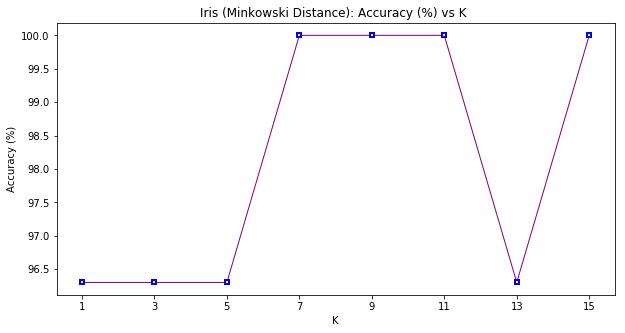

K,accuracy (%),f1_score,precision (%),recall (%)
1,96.3,"{'Iris-setosa': 1.0, 'Iris-virginica': 0.92, 'Iris-versicolor': 0.95}","{'Iris-setosa': 100.0, 'Iris-virginica': 85.71, 'Iris-versicolor': 100.0}","{'Iris-setosa': 100.0, 'Iris-virginica': 100.0, 'Iris-versicolor': 90.0}"
3,96.3,"{'Iris-setosa': 1.0, 'Iris-virginica': 0.92, 'Iris-versicolor': 0.95}","{'Iris-setosa': 100.0, 'Iris-virginica': 85.71, 'Iris-versicolor': 100.0}","{'Iris-setosa': 100.0, 'Iris-virginica': 100.0, 'Iris-versicolor': 90.0}"
5,96.3,"{'Iris-setosa': 1.0, 'Iris-virginica': 0.92, 'Iris-versicolor': 0.95}","{'Iris-setosa': 100.0, 'Iris-virginica': 85.71, 'Iris-versicolor': 100.0}","{'Iris-setosa': 100.0, 'Iris-virginica': 100.0, 'Iris-versicolor': 90.0}"
7,100,"{'Iris-setosa': 1.0, 'Iris-virginica': 1.0, 'Iris-versicolor': 1.0}","{'Iris-setosa': 100.0, 'Iris-virginica': 100.0, 'Iris-versicolor': 100.0}","{'Iris-setosa': 100.0, 'Iris-virginica': 100.0, 'Iris-versicolor': 100.0}"
9,100,"{'Iris-setosa': 1.0, 'Iris-virginica': 1.0, 'Iris-versicolor': 1.0}","{'Iris-setosa': 100.0, 'Iris-virginica': 100.0, 'Iris-versicolor': 100.0}","{'Iris-setosa': 100.0, 'Iris-virginica': 100.0, 'Iris-versicolor': 100.0}"
11,100,"{'Iris-setosa': 1.0, 'Iris-virginica': 1.0, 'Iris-versicolor': 1.0}","{'Iris-setosa': 100.0, 'Iris-virginica': 100.0, 'Iris-versicolor': 100.0}","{'Iris-setosa': 100.0, 'Iris-virginica': 100.0, 'Iris-versicolor': 100.0}"
13,96.3,"{'Iris-setosa': 1.0, 'Iris-virginica': 0.92, 'Iris-versicolor': 0.95}","{'Iris-setosa': 100.0, 'Iris-virginica': 85.71, 'Iris-versicolor': 100.0}","{'Iris-setosa': 100.0, 'Iris-virginica': 100.0, 'Iris-versicolor': 90.0}"
15,100,"{'Iris-setosa': 1.0, 'Iris-virginica': 1.0, 'Iris-versicolor': 1.0}","{'Iris-setosa': 100.0, 'Iris-virginica': 100.0, 'Iris-versicolor': 100.0}","{'Iris-setosa': 100.0, 'Iris-virginica': 100.0, 'Iris-versicolor': 100.0}"


In [21]:
iris_update_distances("Minkowski")

x = list(performance_iris["K"])
y = list(performance_iris["accuracy (%)"])

fig, ax = plt.subplots(figsize=(10,5))

ax.plot(x, y, color="purple", lw=1, ls='-', marker='s', markersize=4, 
        markerfacecolor="yellow", markeredgewidth=2, markeredgecolor="blue");

plt.xticks(x)
plt.title("Iris (Minkowski Distance): Accuracy (%) vs K ")
plt.ylabel("Accuracy (%)")
plt.xlabel("K")
plt.show()

performance_iris.style.hide_index()

## Distance Measure :- Manhattan

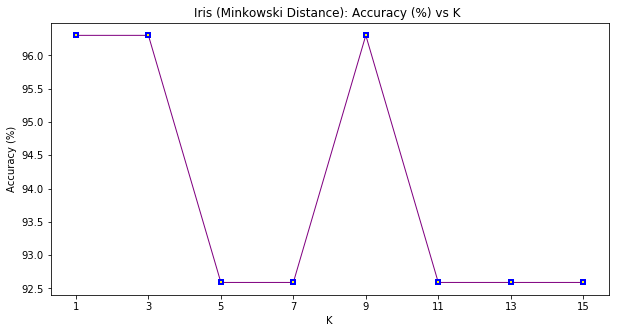

K,accuracy (%),f1_score,precision (%),recall (%)
1,96.3,"{'Iris-setosa': 1.0, 'Iris-virginica': 0.92, 'Iris-versicolor': 0.95}","{'Iris-setosa': 100.0, 'Iris-virginica': 85.71, 'Iris-versicolor': 100.0}","{'Iris-setosa': 100.0, 'Iris-virginica': 100.0, 'Iris-versicolor': 90.0}"
3,96.3,"{'Iris-setosa': 1.0, 'Iris-virginica': 0.92, 'Iris-versicolor': 0.95}","{'Iris-setosa': 100.0, 'Iris-virginica': 85.71, 'Iris-versicolor': 100.0}","{'Iris-setosa': 100.0, 'Iris-virginica': 100.0, 'Iris-versicolor': 90.0}"
5,92.59,"{'Iris-setosa': 1.0, 'Iris-virginica': 0.86, 'Iris-versicolor': 0.89}","{'Iris-setosa': 100.0, 'Iris-virginica': 75.0, 'Iris-versicolor': 100.0}","{'Iris-setosa': 100.0, 'Iris-virginica': 100.0, 'Iris-versicolor': 80.0}"
7,92.59,"{'Iris-setosa': 1.0, 'Iris-virginica': 0.86, 'Iris-versicolor': 0.89}","{'Iris-setosa': 100.0, 'Iris-virginica': 75.0, 'Iris-versicolor': 100.0}","{'Iris-setosa': 100.0, 'Iris-virginica': 100.0, 'Iris-versicolor': 80.0}"
9,96.3,"{'Iris-setosa': 1.0, 'Iris-virginica': 0.92, 'Iris-versicolor': 0.95}","{'Iris-setosa': 100.0, 'Iris-virginica': 85.71, 'Iris-versicolor': 100.0}","{'Iris-setosa': 100.0, 'Iris-virginica': 100.0, 'Iris-versicolor': 90.0}"
11,92.59,"{'Iris-setosa': 1.0, 'Iris-virginica': 0.86, 'Iris-versicolor': 0.89}","{'Iris-setosa': 100.0, 'Iris-virginica': 75.0, 'Iris-versicolor': 100.0}","{'Iris-setosa': 100.0, 'Iris-virginica': 100.0, 'Iris-versicolor': 80.0}"
13,92.59,"{'Iris-setosa': 1.0, 'Iris-virginica': 0.86, 'Iris-versicolor': 0.89}","{'Iris-setosa': 100.0, 'Iris-virginica': 75.0, 'Iris-versicolor': 100.0}","{'Iris-setosa': 100.0, 'Iris-virginica': 100.0, 'Iris-versicolor': 80.0}"
15,92.59,"{'Iris-setosa': 1.0, 'Iris-virginica': 0.86, 'Iris-versicolor': 0.89}","{'Iris-setosa': 100.0, 'Iris-virginica': 75.0, 'Iris-versicolor': 100.0}","{'Iris-setosa': 100.0, 'Iris-virginica': 100.0, 'Iris-versicolor': 80.0}"


In [22]:
iris_update_distances("Manhattan")

x = list(performance_iris["K"])
y = list(performance_iris["accuracy (%)"])

fig, ax = plt.subplots(figsize=(10,5))

ax.plot(x, y, color="purple", lw=1, ls='-', marker='s', markersize=4, 
        markerfacecolor="yellow", markeredgewidth=2, markeredgecolor="blue");

plt.xticks(x)
plt.title("Iris (Minkowski Distance): Accuracy (%) vs K ")
plt.ylabel("Accuracy (%)")
plt.xlabel("K")
plt.show()

performance_iris.style.hide_index()